# RERUN ALL EXPERIREMENTS

### Model 0

#### Model Architecture:

In [2]:
# Loading Data's Vocabulary

import os
import json

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

# Loading Training Dataset's Vocabulary
with open(os.path.join(path_to_data, 'vocab_8k_norm_trainp2_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

In [3]:
import os
import tensorflow as tf

def gen_print_model_stats(model, path):
    m = model()
    if not os.path.exists(os.path.join(path, model.__name__)):
        os.makedirs(os.path.join(path, model.__name__))
    fname = os.path.join(path, model.__name__, model.__name__)
    tf.keras.utils.plot_model(m, fname + '.png', show_shapes=True, expand_nested=True)
    tf.keras.backend.clear_session()
    return m.summary()

In [4]:
import os
import pickle 
import tensorflow as tf

def embedding_matrix(vocab, init, emb_name):
    '''
    Constructs the embedding matrix for specific init type for a pre-initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, emb_name,
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init, emb_name)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, emb_name, doc_embedding_size):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', emb_name=emb_name, mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100, emb_name='current_embedding', 
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, emb_name, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {'adjusted_close_target_WFC': output_layer(time_series_lstm)}
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

In [5]:
import os

gen_print_model_stats(model_0, os.path.join('logs', 'models'))

Model: "model_0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
8-k_WFC (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
8-k_JPM (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
8-k_BAC (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
8-k_C (InputLayer)              [(None, None)]       0                                            
____________________________________________________________________________________________

Graph of Model:
![title](logs/models/model_0/model_0.png)

Talks about model, what loss functione etc.

***

#### Unit Testing Model

##### 1. Testing if when initialized properly, the model is equivalent to the baseline model.

Restart kernel in order to fully clear GPU memory.

In [1]:
# Configuring Virtual GPU and Loading Data

import os
import json
import pickle

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

# Random Seed
seed = 42

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=3000, seed=seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_datasetp2.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)
    
# Loading Train Dataset's Vocabulary
with open(os.path.join(path_to_data, 'vocab_8k_norm_trainp2_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
import tensorflow as tf

from sklearn.model_selection import train_test_split

def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def baseline_model(output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64)
             }
    
    features = tf.keras.layers.Concatenate()([inputs[fname] for fname in inputs.keys() if '8-k' not in fname])
    
    output_layer = tf.keras.layers.Dense(1, kernel_initializer='zeros', bias_initializer=output_bias_init, 
                                         name='adjusted_close_target_WFC')
    
    outputs = {
               'adjusted_close_target_WFC': output_layer(features)
              }
    
    model = tf.keras.Model(inputs, outputs, name='baseline_model')
    
    return model

Defining model.

In [3]:
import os
import pickle
import tensorflow as tf

def embedding_matrix(vocab, init, emb_name):
    '''
    Constructs the embedding matrix for specific init type for a pre-initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, emb_name,
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init, emb_name)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, emb_name, doc_embedding_size):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', emb_name=emb_name, mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100, emb_name='current_embedding', 
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, emb_name, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {
               'adjusted_close_target_WFC': output_layer(time_series_lstm)
              }
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Testing baseline equivalence of model when initialized properly.

In [6]:
import tensorflow as tf

from stockanalysis.train import build_compiled_model

def test_baseline_equivalence(model, baseline_model, batch_size, X, y):
    '''
    Tests baseline equivalence with baseline
    '''
    
    print('Testing if the untrained model when initialized properly is equivalent to the baseline model')
    
    output_bias_init = {key: y[key].mean() for key in y}
    
    loss = tf.keras.losses.MeanSquaredError
    
    hyperparameters_b = {
                         'model_parameters': {'output_bias_init': output_bias_init}, 
                         'training_parameters': {},
                         'loss': loss, 
                         'optimizer': tf.keras.optimizers.Adam, 
                         'optimizer_parameters': {},
                         'version': None
                        }
    
    baseline_m, initial_epoch = build_compiled_model(baseline_model, hyperparameters_b, metrics=[], run_number=None)
    baseline_results = baseline_m.evaluate(X, y, batch_size=batch_size, verbose=0)
    
    model_params = {'output_kernel_init': 'zeros', 'output_bias_init': output_bias_init}
    
    hyperparameters = {
                       'model_parameters': model_params, 
                       'training_parameters': {},
                       'loss': loss, 
                       'optimizer': tf.keras.optimizers.Adam, 
                       'optimizer_parameters': {}, 
                       'version': None
                      }
    
    m1, initial_epoch = build_compiled_model(model, hyperparameters, metrics=[], run_number=None)
    m1_results = m1.evaluate(X, y, batch_size=batch_size, verbose=0)
    
    assert m1_results == baseline_results
    
    return print('Passed')

In [7]:
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)
test_baseline_equivalence(model_0, baseline_model, batch_size=4, X=X, y=y)

Testing if the untrained model when initialized properly is equivalent to the baseline model
Passed


##### 2. Testing if the model trained on real data performs better than the model trained on null data.

###### Using Null Data.

Restart kernel to clear GPU memory.

In [1]:
# Configuring Virtual GPU and Loading Data

import os
import json
import pickle

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

# Random Seed
seed = 42

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=7000, seed=seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_datasetp2.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Train Dataset's Vocabulary
with open(os.path.join(path_to_data, 'vocab_8k_norm_trainp2_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
import numpy as np

from sklearn.model_selection import train_test_split

def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def null_feature(feature_name, feature):
    if 'adjusted_close' in feature_name:
        null_feature = np.zeros(shape=feature.shape, dtype=feature.dtype)
    elif '8-k' in feature_name:
        null_feature = np.ones(shape=feature.shape, dtype=feature.dtype)
    return null_feature

def null_features(features):
    return {fname: null_feature(fname, features[fname]) for fname in features.keys()}

Defining model.

In [3]:
import os
import pickle
import tensorflow as tf

def embedding_matrix(vocab, init, emb_name):
    '''
    Constructs the embedding matrix for specific init type for a pre-initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, emb_name,
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init, emb_name)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, emb_name, doc_embedding_size):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', emb_name=emb_name, mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100, emb_name='current_embedding', 
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, emb_name, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {
               'adjusted_close_target_WFC': output_layer(time_series_lstm)
              }
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Training model on null features.

In [4]:
import tensorflow as tf

from stockanalysis.train import train

# Sampling Data and Nulling Features
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)
X_null = null_features(X)

# Defining Hyperparameters
output_bias_init = {key: y[key].mean() for key in y}
model_params = {'output_bias_init': output_bias_init}
training_params = {'epochs': 2, 'batch_size': 6}

hyperparameters = {
                   'model_parameters': model_params, 
                   'training_parameters': training_params,
                   'loss': tf.keras.losses.MeanSquaredError,
                   'optimizer': tf.keras.optimizers.Adam, 
                   'optimizer_parameters': {}, 
                   'version': None
                  }

# Training Model
model, model_history = train(model_0, hyperparameters, metrics=[], run_number=None, X=X_null, y=y)

Train on 16 samples
Epoch 1/2
16/16 [==============================] - 13s 819ms/sample - loss: 23.4841
Epoch 2/2
16/16 [==============================] - 9s 564ms/sample - loss: 21.4231


Evaluating model.

In [5]:
model_results = model.evaluate(X, y, batch_size=training_params['batch_size'], verbose=0)

In [6]:
print('Metrics for model trained on zeroed features.')
print()
print('Loss for Model: {}'.format(model_results))
print()

Metrics for model trained on zeroed features.

Loss for Model: 20.801743984222412



###### Using Real data.

Restart kernel to clear GPU memory.

In [1]:
# Configuring Virtual GPU and Loading Data

import os
import json
import pickle

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

# Random Seed
seed = 42

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=7000, seed=seed)


# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_datasetp2.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)
    
# Loading Train Dataset's Vocabulary
with open(os.path.join(path_to_data, 'vocab_8k_norm_trainp2_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
from sklearn.model_selection import train_test_split

def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

Defining model.

In [3]:
import os
import pickle
import tensorflow as tf

def embedding_matrix(vocab, init, emb_name):
    '''
    Constructs the embedding matrix for specific init type for a pre-initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, emb_name,
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init, emb_name)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, emb_name, doc_embedding_size):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', emb_name=emb_name, mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100, emb_name='current_embedding', 
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, emb_name, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {
               'adjusted_close_target_WFC': output_layer(time_series_lstm)
              }
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Training model on actual data.

In [4]:
import tensorflow as tf

from stockanalysis.train import train

# Sampling Data
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)

# Defining Hyperparameters
output_bias_init = {key: y[key].mean() for key in y}
model_params = {'output_bias_init': output_bias_init}
training_params = {'epochs': 2, 'batch_size': 6}

hyperparameters = {
                   'model_parameters': model_params, 
                   'training_parameters': training_params,
                   'loss': tf.keras.losses.MeanSquaredError,
                   'optimizer': tf.keras.optimizers.Adam, 
                   'optimizer_parameters': {}, 
                   'version': None
                  }

# Training Model
model, model_history = train(model_0, hyperparameters, metrics=[], run_number=None, X=X, y=y)

Train on 16 samples
Epoch 1/2
16/16 [==============================] - 13s 806ms/sample - loss: 20.9907
Epoch 2/2
16/16 [==============================] - 9s 574ms/sample - loss: 20.4879


Evaluating model.

In [6]:
model_results = model.evaluate(X, y, batch_size=training_params['batch_size'], verbose=0)

In [8]:
print('Metrics for model trained on actual data.')
print()
print('Loss for Model: {}'.format(model_results))

Metrics for model trained on actual data.

Loss for Model: 20.055744647979736


Checks out. The model when trained on actual data has a smaller loss than when trained on the null features.

##### 3. Testing if the model can overfit on a small sample of data.

Restart kernel to clear GPU memory.

In [1]:
# Configuring Virtual GPU and Loading Data

import os
import json
import pickle

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

# Random Seed
seed = 42

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=7000, seed=seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_datasetp2.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)
    
# Loading Train Dataset's Vocabulary
with open(os.path.join(path_to_data, 'vocab_8k_norm_trainp2_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        #print(list(range(len(true_labels.keys()))))
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    name = ts_fname.split('_')
    ticker = name.pop()
    name = '_'.join(name)
    target = targets['_'.join([name, 'target', ticker])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([name, 'target', ticker]):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history[metric], label='Train')
    if 'val_' + metric in history:
        ax.plot(history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

Defining model.

In [3]:
import os
import pickle 
import tensorflow as tf

def embedding_matrix(vocab, init, emb_name):
    '''
    Constructs the embedding matrix for specific init type for a pre-initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, emb_name,
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init, emb_name)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, emb_name, doc_embedding_size):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', emb_name=emb_name, mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100, emb_name='current_embedding', 
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, emb_name, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {
               'adjusted_close_target_WFC': output_layer(time_series_lstm)
              }
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Overtraining model on a small sample of the data.

In [4]:
import tensorflow as tf

from stockanalysis.train import build_compiled_model

def overfit_small_sample(model, batch_size, epochs, X_small, y_small, verbose):
    print('Testing if model can overfit on a small sample of data')
    
    # Defining Model Hyperparameters for Test
    output_bias_init = {key: y_small[key].mean() for key in y_small}
    model_params = {'output_bias_init': output_bias_init}
    training_params = {'epochs': epochs, 'batch_size': batch_size}
    hyperparameters = {
                       'model_parameters': model_params, 
                       'training_parameters': training_params,
                       'loss': tf.keras.losses.MeanSquaredError, 
                       'optimizer': tf.keras.optimizers.Adam,
                       'optimizer_parameters': {},
                       'version': None
                      }
    
    m, initial_epoch = build_compiled_model(model, hyperparameters, metrics=[], run_number=None)
    m_pred_untrained = m.predict(X_small, batch_size=batch_size)
    m_history = m.fit(X_small, y_small, **training_params, initial_epoch=initial_epoch, verbose=verbose)
    m_pred_trained = m.predict(X_small, batch_size=batch_size)
    
    print()
    print('Plotting Error against Sample for Before Training, and After Training on the Small Dataset')
    plot_outputs_errors(m_pred_untrained, y_small, 'Before Training')
    plot_outputs_errors(m_pred_trained, y_small, 'After Training')
    print()
    
    print('Plotting Each Sample\'s Time Series')
    plot_ts_samples_ba(X_small, y_small, m_pred_untrained, m_pred_trained, 'adjusted_close_WFC')
    
    metrics = m.metrics_names
    for met in metrics:
        plot_metric(m_history.history, metric=met)
        
    return None

Testing if model can overfit on a small sample of data
Train on 2 samples
Epoch 1/2
2/2 [==============================] - 7s 4s/sample - loss: 21.8624
Epoch 2/2
2/2 [==============================] - 4s 2s/sample - loss: 21.5307
Plotting Error against Sample for Before Training, and After Training on the Small Dataset
[0]


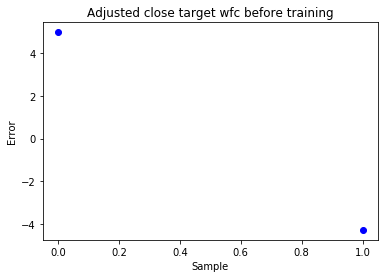

[0]


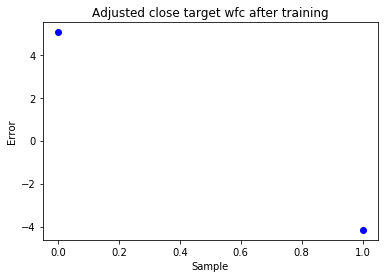


Plotting Each Sample's Time Series


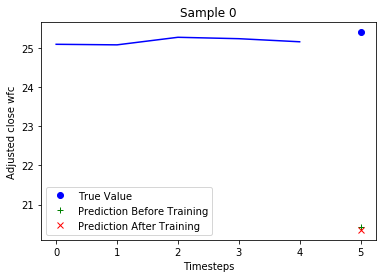

True Target Value: 25.3963
Predicted Target Value Before Training: 20.42641258239746
Predicted Target Value After Training: 20.351648330688477




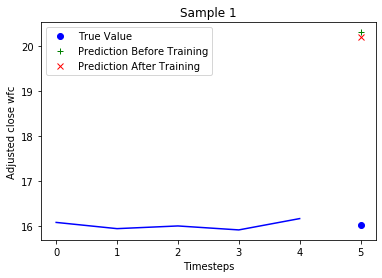

True Target Value: 16.0382
Predicted Target Value Before Training: 20.30572509765625
Predicted Target Value After Training: 20.192684173583984




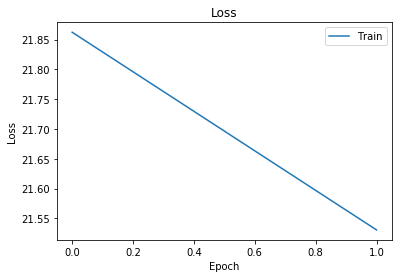

In [5]:
X_small, y_small = sample_dataset(train_dataset, sample_size=2, seed=seed)

del y_small['adjusted_close_target_JPM']
del y_small['adjusted_close_target_BAC']
del y_small['adjusted_close_target_C']

overfit_small_sample(model_0, batch_size=1, epochs=2, X_small=X_small, y_small=y_small, verbose=1)

From the above plots its clear that our model has overfit on our small sample of the dataset which is the desired behavior.

***

#### Evaluating Model:

Restart kernel to clear GPU memory.

In [1]:
# Configuring Virtual GPU and Loading Data

import os
import json
import pickle

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

# Random Seed
seed = None

# Configuring GPU and TensorFlow
config_hardware(gpu_memory=7000, seed=seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_datasetp2.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'val_datasetp2.pickle'), 'rb') as f:
    val_dataset = pickle.load(f)
    
# Loading Train Dataset's Vocabulary
with open(os.path.join(path_to_data, 'vocab_8k_norm_trainp2_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history[metric], label='Train')
    if 'val_' + metric in history:
        ax.plot(history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

def print_metric(metrics_values, metric_idx, name):
    if isinstance(metrics_values, list):
        metric_val = metrics_values[metric_idx]
    else: 
        metric_val = metrics_values
    return print(name.format(metric_val))
    
def plot_print_metrics(history, metrics_train, metrics_val, metrics_names):
    for metric_idx, metric_name in enumerate(metrics_names):
        plot_metric(history, metric_name)
        name_train = metric_name.replace('_', ' ').capitalize() + ' on train dataset: {}'
        print_metric(metrics_train, metric_idx, name_train)
        name_val = metric_name.replace('_', ' ').capitalize() + ' on validation dataset: {}'
        print_metric(metrics_val, metric_idx, name_val)
    return None

def plot_print_complete_metrics(model_name, model_version, run_number, metrics_train, metrics_val, metrics_names):
    csvlog = os.path.join('logs', 'models', model_name, '_'.join(['version', str(model_version)]), 'runs', str(run_number), 'history.log')
    df = pd.read_csv(csvfile).drop_duplicates(subset='epoch', keep='last').set_index('epoch')
    plot_print_metrics(df, metrics_train=metrics_train, metrics_val=metrics_val, metrics_names=metrics_names)
    return None

Defining model.

In [3]:
import os
import pickle
import tensorflow as tf

def embedding_matrix(vocab, init, emb_name):
    '''
    Constructs the embedding matrix for specific init type for a pre-initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = os.path.join('~', '.stockanalysis', 'model_resources', 'glove')
        glove_dir = os.path.expanduser(glove_dir)
        
        try:
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, '{}.pickle'.format(emb_name)), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, emb_name,
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init, emb_name)
        emb_layer = tf.keras.layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                              weights=[current_embedding_matrix], mask_zero=mask_zero,
                                              input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = tf.keras.layers.Embedding(len(vocab) + 1, output_dim=init, 
                                              embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                              activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                              mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer

def document_embedder_model(vocab, emb_name, doc_embedding_size):
    input_doc = tf.keras.Input(shape=(None,), name='doc')
    word_embedding = Word_Embedding(vocab, init='glove', emb_name=emb_name, mask_zero=False, trainable=False)(input_doc)
    document_embedding = tf.keras.layers.LSTM(doc_embedding_size)(word_embedding)
    model = tf.keras.Model(input_doc, document_embedding, name='document_embedder')
    return model

def model_0(lstm_layer_units=32, vocab=vocab, doc_embedding_size=100, emb_name='current_embedding', 
            output_kernel_init=None, output_bias_init=None):
    
    if output_bias_init is not None:
        output_bias = output_bias_init['adjusted_close_target_WFC']
        output_bias_init = tf.keras.initializers.Constant(output_bias)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    doc_embedder = document_embedder_model(vocab, emb_name, doc_embedding_size)
    document_embeddings = [doc_embedder(inputs[fname]) for fname in inputs.keys() if '8-k' in fname]
    
    reshape_doc_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stack([x for i in range(5)], axis=1))
    reshaped_doc_embeddings = [reshape_doc_embedding(doc_embedding) for doc_embedding in document_embeddings]
    
    reshape_price_feature = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped_price_features = [reshape_price_feature(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    time_series_input = tf.keras.layers.Concatenate()(reshaped_doc_embeddings + reshaped_price_features)
    
    time_series_lstm = tf.keras.layers.LSTM(lstm_layer_units)(time_series_input)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='adjusted_close_target_WFC')
    outputs = {
               'adjusted_close_target_WFC': output_layer(time_series_lstm)
              }
    
    
    model = tf.keras.Model(inputs, outputs, name='model_0')
    
    return model

Inspecting both are training and validation datasets.

In [4]:
X_train, y_train = train_dataset
X_val, y_val = val_dataset

print('Feature names and shapes for Training Data:')
for key in X_train:
    print('{}: {}'.format(key, X_train[key].shape[1:]))
print()
print('Feature names and shapes for Validation Data:')
for key in X_val:
    print('{}: {}'.format(key, X_val[key].shape[1:]))
print()
print('Train set size: {}'.format(len(y_train['adjusted_close_target_WFC'])))
print('Validation set size: {}'.format(len(y_val['adjusted_close_target_WFC'])))

Feature names and shapes for Training Data:
adjusted_close_WFC: (5,)
8-k_WFC: (1562,)
adjusted_close_JPM: (5,)
8-k_JPM: (90363,)
adjusted_close_BAC: (5,)
8-k_BAC: (15826,)
adjusted_close_C: (5,)
8-k_C: (53958,)

Feature names and shapes for Validation Data:
adjusted_close_WFC: (5,)
8-k_WFC: (1364,)
adjusted_close_JPM: (5,)
8-k_JPM: (1706,)
adjusted_close_BAC: (5,)
8-k_BAC: (2026,)
adjusted_close_C: (5,)
8-k_C: (2636,)

Train set size: 3014
Validation set size: 1001


Building model.

In [5]:
import tensorflow as tf

# Defining Hyperparameters
output_bias_init = {key: y_train[key].mean() for key in y_train}
model_params = {
                'output_bias_init': output_bias_init, 
                'lstm_layer_units': 32
               }
training_params = {
                   'batch_size': 6, 
                   'epochs': 2
                  }
loss = tf.keras.losses.MeanSquaredError
optimizer = tf.keras.optimizers.Adam
optimizer_params = {}

model_version = 0
hyperparameters = {
                   'model_parameters': model_params,
                   'training_parameters': training_params,
                   'loss': loss, 
                   'optimizer': optimizer, 
                   'optimizer_parameters': optimizer_params, 
                   'version': model_version
                  }

# Defining Metrics
metrics = []

# Setting unique Run Number 
run_number = 0

Training model.

In [6]:
from stockanalysis.train import train

model, model_history = train(model_0, hyperparameters, metrics, run_number, X_train, y_train, (X_val, y_val), True, True, True)

Restored model from: logs/models/model_0/version_0/runs/0/checkpoints/cp-1.ckpt
Saved hyperparameters to file: logs/models/model_0/version_0
Train on 3014 samples, validate on 1001 samples
Epoch 1/2
  48/3014 [..............................] - ETA: 29:11 - loss: 4.6273
Epoch 00001: saving model to logs/models/model_0/version_0/runs/0/checkpoints/cp-1.ckpt
  48/3014 [..............................] - ETA: 29:15 - loss: 4.6273

KeyboardInterrupt: 

Evaluating model.

In [ ]:
# Gathering Data

import numpy as np

metrics_train = model.evaluate(X_train, y_train, batch_size=training_params['batch_size'], verbose=0)
metrics_val = model.evaluate(X_val, y_val, batch_size=training_params['batch_size'], verbose=0)
m_preds_train = model.predict(X_train, batch_size=training_params['batch_size'])
m_preds_val = model.predict(X_val, batch_size=training_params['batch_size'])
m_preds_up_train = ((m_preds_train[1:, 0] - y_train['adjusted_close_target_WFC'][:-1]) > 0).astype(int)
m_preds_up_val = ((m_preds_val[1:, 0] - y_val['adjusted_close_target_WFC'][:-1]) > 0).astype(int)
labels_up_train = ((y_train['adjusted_close_target_WFC'][1:] - y_train['adjusted_close_target_WFC'][:-1]) > 0).astype(int)
labels_up_val = ((y_val['adjusted_close_target_WFC'][1:] - y_val['adjusted_close_target_WFC'][:-1]) > 0).astype(int)
up_cls_acc_train = np.mean(np.equal(m_preds_up_train, labels_up_train))
up_cls_acc_val = np.mean(np.equal(m_preds_up_val, labels_up_val))

Learning Curves for Metrics:


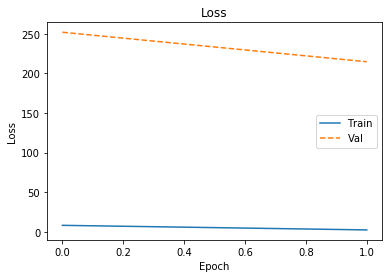

Loss on train dataset: 1.8115987953122437
Loss on validation dataset: 214.70029630479993

Metrics for Classifying Upward Movements
Accuracy on train dataset: 0.9193494855625622
Accuracy on validation dataset: 0.578


In [23]:
# Reporting Data

print('Learning Curves for Metrics:')
plot_print_metrics(model_history.history, metrics_train=metrics_train, metrics_val=metrics_val, metrics_names=model.metrics_names)
print()
print('Metrics for Classifying Upward Movements')
print('Accuracy on train dataset: {}'.format(up_cls_acc_train))
print('Accuracy on validation dataset: {}'.format(up_cls_acc_val))

Complete Learning Curves for Metrics: 


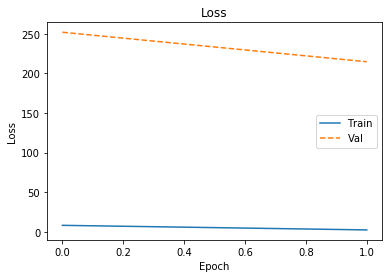

Loss on train dataset: 1.8115987953122437
Loss on validation dataset: 214.70029630479993


In [26]:
print('Complete Learning Curves for Metrics: ')
plot_print_complete_metrics('model_0', model_version, run_number, metrics_train=metrics_train, metrics_val=metrics_val, metrics_names=model.metrics_names)